In [63]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical, Sequence

In [64]:
BASE_DIR = r"C:\Users\ssanj\OneDrive\Desktop\w\telesto\telesto\datasets"
CSV_FILE = os.path.join(BASE_DIR, "boneage-training-dataset.csv")
IMAGE_DIR = r"C:\Users\ssanj\OneDrive\Desktop\w\telesto\telesto\datasets\boneage-training-dataset\boneage-training-dataset"

df = pd.read_csv(CSV_FILE)

# Debugging output
print("First 5 rows:\n", df.head())
print("\nUnique values in 'male':", df['male'].unique())
print("\nMissing values:\n", df.isnull().sum())

First 5 rows:
      id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False

Unique values in 'male': [False  True]

Missing values:
 id         0
boneage    0
male       0
dtype: int64


In [65]:
if df['male'].dtype == bool:
    df['male'] = df['male'].astype(int)
else:
    df['male'] = df['male'].astype(str).str.lower().map({'true': 1, 'false': 0})


In [66]:
# Drop rows with missing values in 'boneage' or 'male'
df = df.dropna(subset=['boneage', 'male'])

# Select features and scale
X = df[['boneage', 'male']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [67]:
# Apply KMeans clustering (2 clusters)
kmeans_csv = KMeans(n_clusters=2, random_state=42, n_init=10)
df['csv_cluster'] = kmeans_csv.fit_predict(X_scaled)

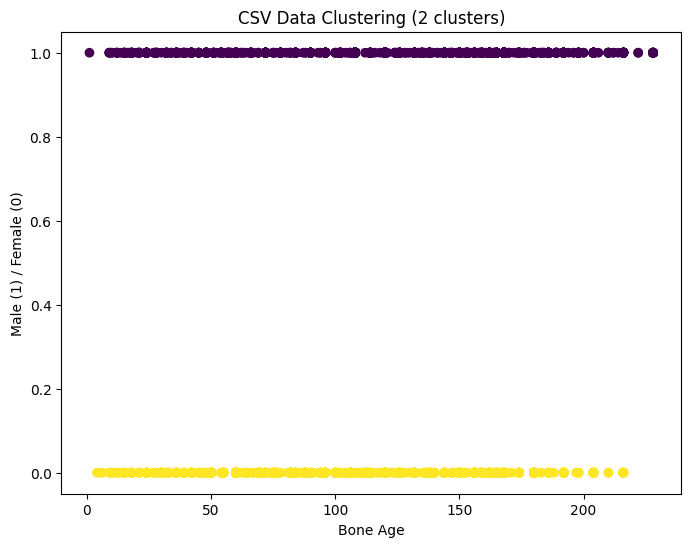

In [68]:
# Plot the clusters
plt.figure(figsize=(8,6))
plt.scatter(df['boneage'], df['male'], c=df['csv_cluster'], cmap='viridis')
plt.xlabel("Bone Age")
plt.ylabel("Male (1) / Female (0)")
plt.title("CSV Data Clustering (2 clusters)")
plt.show()

In [69]:
print("\nClustered Data Sample:")
print(df[['id','boneage','male','csv_cluster']].head(10))


Clustered Data Sample:
     id  boneage  male  csv_cluster
0  1377      180     0            1
1  1378       12     0            1
2  1379       94     0            1
3  1380      120     1            0
4  1381       82     0            1
5  1382      138     1            0
6  1383      150     1            0
7  1384      156     1            0
8  1385       36     1            0
9  1387      138     1            0


In [70]:
IMG_SIZE = 128
NUM_CLUSTERS = 4

In [71]:
# Build file map
available_files = {}
for filename in os.listdir(IMAGE_DIR):
    file_id, ext = os.path.splitext(filename)
    if ext.lower() in ['.png', '.jpg', '.jpeg']:
        available_files[file_id] = filename
print(f"Total image files found: {len(available_files)}")

Total image files found: 12611


In [72]:
def safe_read(img_dir, img_id):
    """Load grayscale image by ID with extension handling"""
    for ext in [".png", ".jpg", ".jpeg"]:
        path = os.path.join(img_dir, str(img_id) + ext)
        if os.path.exists(path):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                return cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return None

In [73]:
# Load images and normalize
images = []
ids = []
for img_id in tqdm(df['id'][:1000]):  # limit to 1000 images
    img = safe_read(IMAGE_DIR, img_id)
    if img is not None:
        img = img / 255.0  # normalize
        images.append(img.flatten())
        ids.append(img_id)

X_images = np.array(images)
print("Image dataset shape:", X_images.shape)
if len(images) == 0:
    raise Exception("No images were loaded! Check IMAGE_DIR and file names.")

# PCA to reduce dimension
pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X_images)

# KMeans clustering
kmeans_img = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
clusters = kmeans_img.fit_predict(X_reduced)

  0%|          | 0/1000 [00:00<?, ?it/s]

Image dataset shape: (1000, 16384)


In [74]:
# Save cluster labels
df_img_clusters = pd.DataFrame({"id": ids, "image_cluster": clusters})
print(df_img_clusters.head())

     id  image_cluster
0  1377              0
1  1378              2
2  1379              2
3  1380              1
4  1381              2


In [75]:
# PCA to reduce dimensions to 50
pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X_images)

# KMeans clustering
kmeans_img = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
clusters = kmeans_img.fit_predict(X_reduced)

# Save cluster labels
df_img_clusters = pd.DataFrame({"id": ids, "image_cluster": clusters})
print(df_img_clusters.head())

     id  image_cluster
0  1377              0
1  1378              2
2  1379              2
3  1380              1
4  1381              2


In [76]:
# PCA to 2D for visualization
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_images)

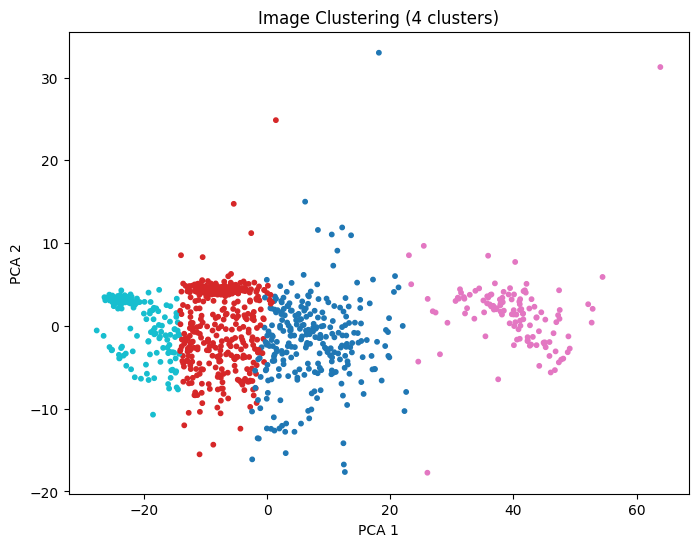

In [77]:
plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters, cmap="tab10", s=10)
plt.title("Image Clustering (4 clusters)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [81]:
# Merge CSV and Image cluster results
# -----------------------
df['id'] = df['id'].astype(str)
df_img_clusters['id'] = df_img_clusters['id'].astype(str)

df_merged = pd.merge(df, df_img_clusters, on="id", how="inner")

print("\n Merged Data:")
print(df_merged[['id', 'boneage', 'male', 'csv_cluster', 'image_cluster']].head(20))


 Merged Data:
      id  boneage  male  csv_cluster  image_cluster
0   1377      180     0            1              0
1   1378       12     0            1              2
2   1379       94     0            1              2
3   1380      120     1            0              1
4   1381       82     0            1              2
5   1382      138     1            0              0
6   1383      150     1            0              2
7   1384      156     1            0              2
8   1385       36     1            0              1
9   1387      138     1            0              0
10  1388      126     0            1              1
11  1389      138     1            0              1
12  1390      156     1            0              2
13  1391      180     1            0              1
14  1393      132     0            1              2
15  1394       57     1            0              2
16  1395      120     0            1              2
17  1396      188     0            1             


CSV vs Image Cluster Crosstab:
 image_cluster    0    1   2   3
csv_cluster                    
0              150  248  57  93
1              121  194  65  72


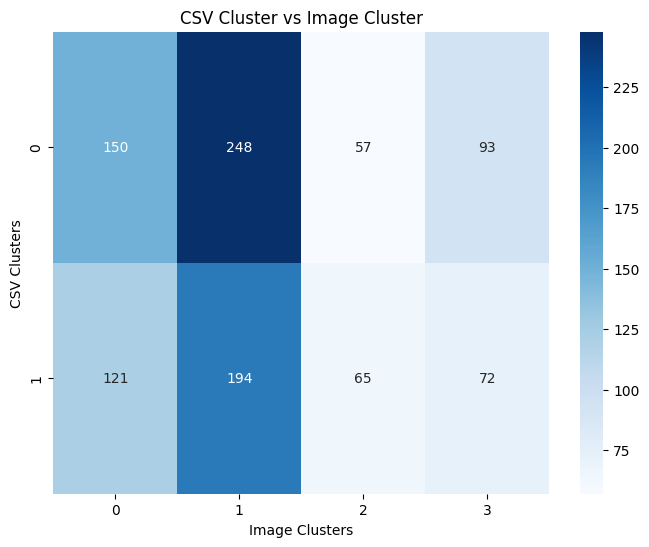

In [79]:
# Crosstab analysis
crosstab = pd.crosstab(df_merged['csv_cluster'], df_merged['image_cluster'])
print("\nCSV vs Image Cluster Crosstab:\n", crosstab)

# Visualize the crosstab with heatmap
plt.figure(figsize=(8,6))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="Blues")
plt.title("CSV Cluster vs Image Cluster")
plt.xlabel("Image Clusters")
plt.ylabel("CSV Clusters")
plt.show()

In [83]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.stats import chi2_contingency
import numpy as np

In [84]:
# Make sure your cluster columns are in df_merged
csv_clusters = df_merged['csv_cluster']
image_clusters = df_merged['image_cluster']

In [86]:
# 1️Cramér's V
crosstab = pd.crosstab(csv_clusters, image_clusters)
chi2 = chi2_contingency(crosstab)[0]
n = crosstab.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
print(f"Cramér's V between CSV and Image clusters: {cramers_v:.3f}")

# 2️Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(csv_clusters, image_clusters)
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")

# 3️Adjusted Rand Index (ARI)
ari = adjusted_rand_score(csv_clusters, image_clusters)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

# Optional: summary table
metrics_df = pd.DataFrame({
    'Metric': ['Cramér\'s V', 'Normalized Mutual Information', 'Adjusted Rand Index'],
    'Score': [cramers_v, nmi, ari]
})
print("\nCluster Correlation Metrics Summary:")
print(metrics_df)

Cramér's V between CSV and Image clusters: 0.061
Normalized Mutual Information (NMI): 0.002
Adjusted Rand Index (ARI): 0.001

Cluster Correlation Metrics Summary:
                          Metric     Score
0                     Cramér's V  0.060960
1  Normalized Mutual Information  0.001889
2            Adjusted Rand Index  0.001423


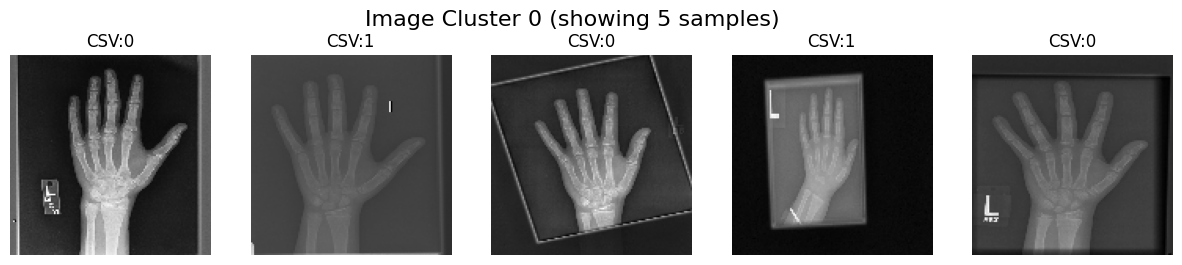

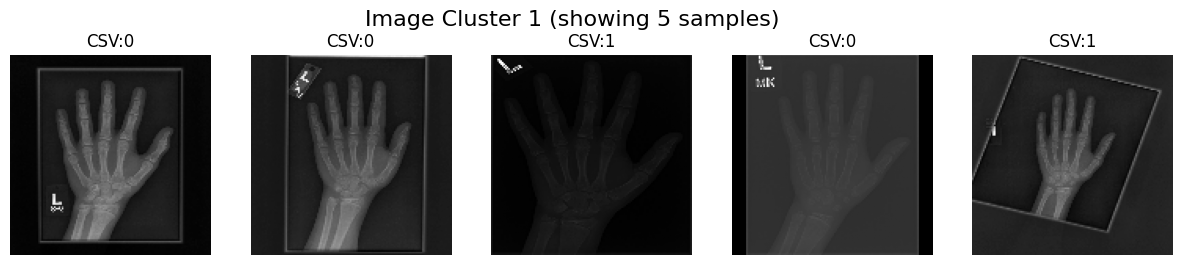

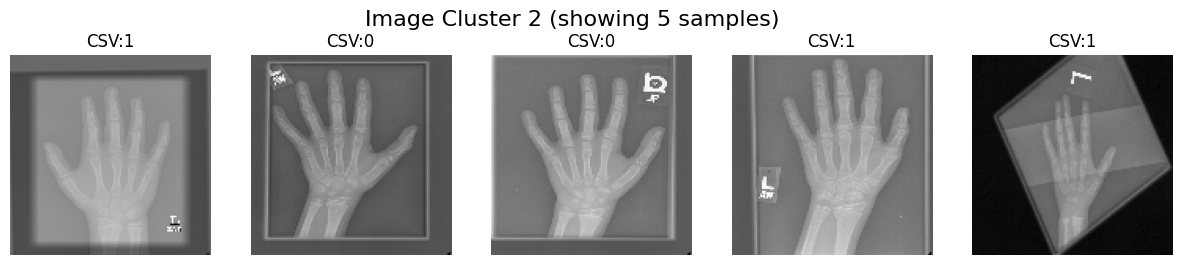

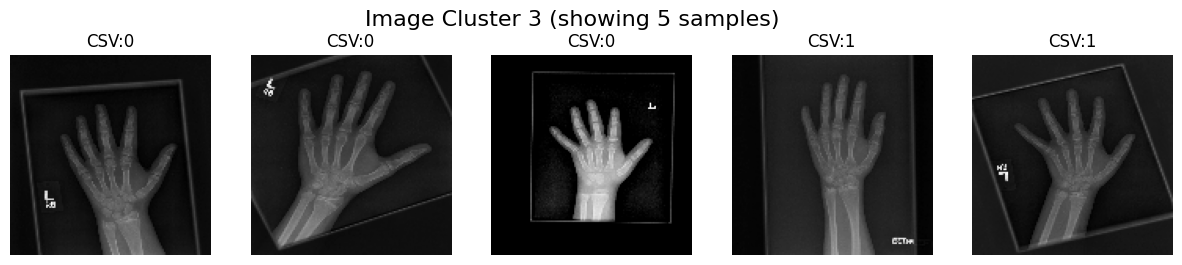

In [87]:
import matplotlib.pyplot as plt
import random

# Number of images to display per image cluster
NUM_SAMPLES = 5

# Loop through each image cluster
for cluster_id in sorted(df_merged['image_cluster'].unique()):
    # Filter IDs belonging to this image cluster
    cluster_ids = df_merged[df_merged['image_cluster'] == cluster_id]['id'].tolist()
    
    # Randomly sample a few images from this cluster
    sample_ids = random.sample(cluster_ids, min(NUM_SAMPLES, len(cluster_ids)))
    
    plt.figure(figsize=(15,3))
    plt.suptitle(f"Image Cluster {cluster_id} (showing {len(sample_ids)} samples)", fontsize=16)
    
    for i, img_id in enumerate(sample_ids):
        img = safe_read(IMAGE_DIR, img_id)
        if img is not None:
            csv_cluster = df_merged[df_merged['id'] == img_id]['csv_cluster'].values[0]
            
            plt.subplot(1, NUM_SAMPLES, i+1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(f"CSV:{csv_cluster}")
    
    plt.show()
